In [2]:
# import necessary packages
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pmdarima as pm
from prophet import Prophet
from pylab import rcParams
from itertools import product
from tqdm import tqdm_notebook

In [3]:
# loading the data - data is provided in excel format
xls = pd.ExcelFile('data_file.xlsx')

In [4]:
# read the data in WaterWorksData sheet and read the right  columns and rows
df1 = pd.read_excel(xls, 'WaterWorksData',skiprows=[1,2,3,4,5],names=['date','yvw','cww','sew','t','r','total'])
df1['date']=pd.to_datetime(df1.date,format="%Y-%m-%d")
df1.head()

,date,yvw,cww,sew,t,r,total
0,2007-01-01,427,234,392,29.0,0.4,1053
1,2007-01-02,372,208,345,28.0,0.0,925
2,2007-01-03,469,285,414,30.0,0.0,1168
3,2007-01-04,491,294,443,33.0,0.0,1228
4,2007-01-05,437,295,424,34.0,0.0,1156


In [5]:
# get basic statistics of the data, here the yvw,cww and sew are three different entitities which records the water 
# consumption in those areas, total consumption would be the summation of all, t - max temperature andr - rainfall
df1.describe()

,yvw,cww,sew,t,r,total
count,4905.000000,4905.000000,4905.000000,4905.000000,4905.000000,4905.000000
mean,402.954740,282.638328,389.996126,21.048909,1.733007,1075.589195
std,68.027304,40.424194,63.353930,7.311028,5.112720,166.953176
min,245.000000,137.000000,218.000000,7.300000,0.000000,754.000000
25%,357.000000,253.000000,343.000000,15.100000,0.000000,955.000000
50%,384.000000,277.000000,377.000000,19.800000,0.000000,1039.000000
75%,431.000000,303.000000,419.000000,25.800000,1.000000,1148.000000
max,778.000000,478.000000,700.000000,45.000000,106.000000,1941.000000


In [6]:
# validate the trend is stationary or non stationary
# H0-non stationary, H1-stationary
result=adfuller(df1.total)
print('ADF Statistics: %f'%result[0])
print('p-value: %f'%result[1])

ADF Statistics: -4.118709
p-value: 0.000902


In [7]:
# failed to reject H1 at 95% confidence interval

<AxesSubplot:xlabel='date'>

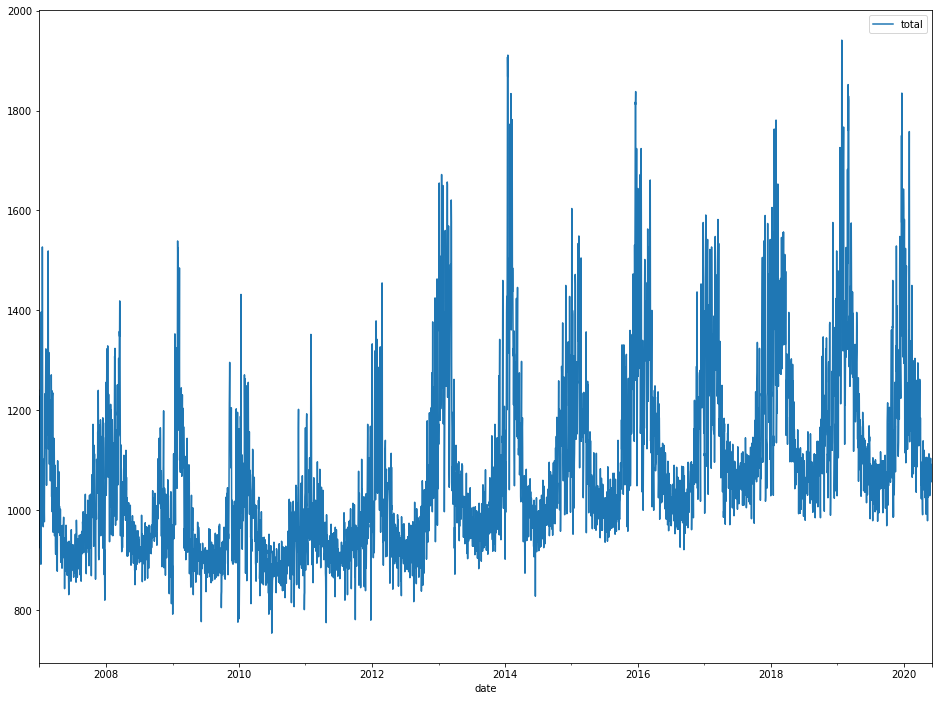

In [9]:
# just see the trend
df1.plot(x='date',y='total',figsize=(16,12))